In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X, y = fetch_covtype(as_frame=True, return_X_y=True)

In [3]:
# splitting into train and test using a stratified split 
# and 80-20 train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [4]:
# Describing the index of numerical and categorical variables
num_vars = X.columns[:10]
cat_vars = X.columns[10:]

In [5]:
# Standard Scaling the numerical variables
ct = ColumnTransformer(
    [("num_transforms", StandardScaler(), num_vars),
     ("cat_transforms", SelectKBest(), cat_vars)],
    remainder="passthrough"
)

# clf is HistGradientBoostingClassifier with f1 scoring function
clf = HistGradientBoostingClassifier(
    scoring="f1_macro")

# Combining the two steps into a pipeline
pipe = Pipeline([("ct",ct), ("clf", clf)])

In [6]:
# generates a list of dicts to be used as parameters for a grid search
from sklearn.feature_selection import mutual_info_classif


def param_generator(k_values):
    param_dicts = []
    for k in k_values:
        params = dict(
            ct__cat_transforms__k=[k],
            ct__cat_transforms__score_func=[chi2, mutual_info_classif], 
            clf__categorical_features=
            [np.concatenate((np.zeros(10, dtype='bool'),np.ones(k, dtype="bool")))])
        param_dicts.append(params)
    return param_dicts

In [7]:
k_values = np.array(range(1, 45, 1))
param_dicts = param_generator(k_values)
output = GridSearchCV(pipe, param_dicts, scoring="f1_macro", verbose=1)


In [8]:
output.fit(X_train, y_train)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_transforms',
                                                                         StandardScaler(),
                                                                         Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fir...
                         {'clf__categorical_features': [array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])],
                          'ct__cat_transforms__k': [30],
                          'ct__cat_transforms__score_func': [<function chi2 at 0x7f745e2f39a0>,
                                                             <function mutual_info_classif at 0x7f745e3225f0>]}, ...],
             scoring='f1_macro', verbose=1)

In [9]:
results = output.cv_results_

In [10]:
list(results)

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_clf__categorical_features',
 'param_ct__cat_transforms__k',
 'param_ct__cat_transforms__score_func',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [17]:
# results['mean_test_score']

In [32]:
score = results['mean_test_score']

In [28]:
k_vals = np.array(results['param_ct__cat_transforms__k'])

In [31]:
score_func = np.array(results['param_ct__cat_transforms__score_func'])

[Text(0.5, 0, 'K'),
 Text(0, 0.5, 'CV Score'),
 Text(0.5, 1.0, 'CV Mean Score vs. K')]

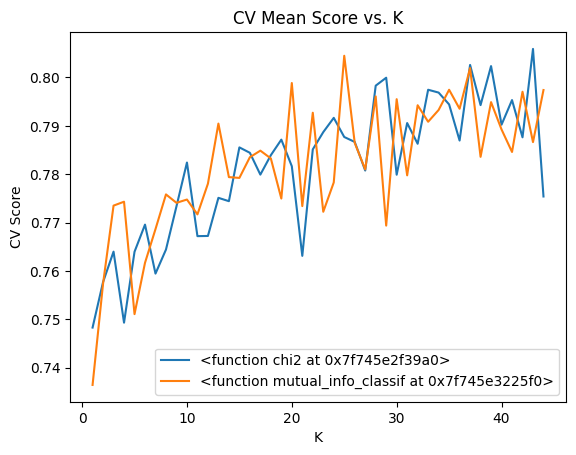

In [41]:
ax = sns.lineplot(x=k_vals, y=score, hue=score_func)
ax.set(xlabel="K", ylabel="CV Score", title="CV Mean Score vs. K")

In [ ]:
# For both feature reduction techniques, it looks like the model does not achieve higher 
# accuracy when features are removed.  The results may have been different if the model
# were something like a logistic regression.